In [1]:
%pprint

Pretty printing has been turned OFF


## 2016 Election Project 

This notebook is intended to document NER annotation of my data throughout this project. The data I am starting out with are transcripts of the presidential debates from the 2016 US Election- the 10 Democratic primary debates, the 12 Republican primary debates, and the debates for the general election between Hillary Clinton and Donald Trump. The transcripts were taken from UCSB's American Presidency Project. The citations for these transcripts can be found in the README.

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import re

**I'm going to create a mapping function that will take the sentence in each row of each data frame and perform nltk's chunking operation on it to get a tree with annoted NEs**

In [3]:
#Import the saved list of data frames I created in secondary_data_processing
import pickle
f = open('/Users/Paige/Documents/Data_Science/2016-Election-Project/data/Debates/csv/dataframes.p', 'rb')
dataframes = pickle.load(f)
f.close()

In [4]:
df1 = dataframes[0]

In [5]:
df1.head()

,Date,Debate Type,Speaker,Sents
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h..."


In [6]:
def get_tree(sent):
    sents = nltk.sent_tokenize(sent)
    words = [nltk.word_tokenize(sent) for sent in sents]
    pos = [nltk.pos_tag(sent) for sent in words]
    chunk = nltk.ne_chunk_sents(pos)
    return list(chunk)

In [9]:
for df in dataframes:
    df['Tree']=df.Sents.map(get_tree)

In [46]:
df1 = dataframes[0]
df1.head()

,Date,Debate Type,Speaker,Sents,Tree
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...,"[[(It, PRP), (is, VBZ), (9:00, CD), (p.m., NN)..."
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...,"[[(Welcome, VB), (to, TO), (the, DT), (sixth, ..."
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo...","[[(I, PRP), ('m, VBP), [('Neil', 'JJ'), ('Cavu..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...,"[[(Tonight, NN), (we, PRP), (are, VBP), (worki..."
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h...","[[(And, CC), (according, VBG), (to, TO), [('Fa..."


In [47]:
for df in dataframes:
    for row in range(0, len(df)):
        df.iloc[row][-1][0].set_label(df.iloc[row][2])

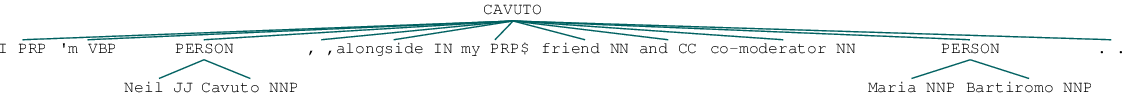

In [51]:
dataframes[0].iloc[2]['Tree'][0]

In [54]:
dataframes[0].iloc[2]['Speaker']

'CAVUTO'

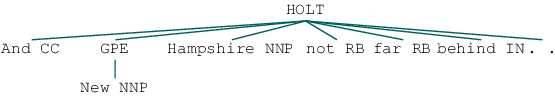

In [52]:
dataframes[1].iloc[2]['Tree'][0]

In [55]:
dataframes[1].iloc[2]['Speaker']

'HOLT'

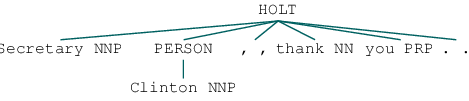

In [53]:
dataframes[-1].iloc[50]['Tree'][0]

In [56]:
dataframes[-1].iloc[2]['Speaker']

'HOLT'

In [ ]:
#This section is with help from a datacamp tutorial
#https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/named-entity-recognition?ex=3

ner_categories = defaultdict(int)

# Create the nested for loop
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

In [ ]:
people = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'PERSON':
                people.append(chunk)

In [ ]:
gpe = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'GPE':
                gpe.append(chunk)

In [ ]:
org = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'ORGANIZATION':
                org.append(chunk)

In [ ]:
facility = []
for sent in d1chunked_sents:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'FACILITY':
                facility.append(chunk)

In [ ]:
len(people)

In [ ]:
len(gpe)

In [ ]:
len(org)

In [ ]:
len(facility)

In [ ]:
for x in facility:
    print(x)

In [ ]:
for x in org:
    print(x)

In [ ]:
people[1].leaves()[0][0]
words = [leaf[0] for leaf in people[1].leaves()]
words

In [ ]:
people_names = []
name = ''
for tree in people:
    for leaf in tree.leaves():
        name+=' '+str(leaf[0])
    people_names.append(name.strip())
    name = ''


In [ ]:
set(people_names)

In [ ]:
'Secretary' in people_names

In [ ]:
'Secretary Clinton' in debate1

In [ ]:
'Secretary Clinton' in people_names
#In fact it looks like it never recognizes Secretary Clinton as a PERSON. Just 'Clinton'